## Introduction

The goal of this project is to develop a model that classifies types of supernovae based on their light curves, specifically focusing on photometric data. The task at hand is to distinguish between two primary types of supernovae: Type I (SN I) and Type II (SN II) through binary classification.

This study draws inspiration from a research paper which explores advanced preprocessing methods for constructing light curves using Gaussian processes. The paper, which can be accessed [here](https://arxiv.org/abs/2105.06178), details the use of Gaussian processes to smooth and interpolate the raw photometric data, thereby facilitating better feature extraction for subsequent classification tasks.

The model we intend to build, referred to as "T2", is based on the transformer architecture.In this project, we leverage the transformer model to process the time-series data derived from the light curves of supernovae, aiming to efficiently classify these astronomical events into their respective types.

## Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

#import importlib
#import src.preprocessing.tools as tools
#import src.preprocessing.load_csv as load_csv
#import src.preprocessing.plot_data as plot_data
#import src.preprocessing.data_augmentation as data_augmentation
#import src.evaluation.plot_evaluation as plot_evaluation

#importlib.reload(plot_evaluation)
#importlib.reload(data_augmentation)
#importlib.reload(load_csv)
#importlib.reload(plot_data)
#importlib.reload(tools)

#from src.preprocessing.load_csv import load_BTS_data, load_all_photometry
#from src.preprocessing.plot_data import plot_types_distributions, plot_photometry, plot_gp
#from src.preprocessing.tools import categorize_type, Mag2Flux, Normalize_mjd, count_obj_by_type, robust_scale
#from src.preprocessing.data_augmentation import augment_data_with_noise, balanced_augmentation
#from src.evaluation.plot_evaluation import plot_history, plot_multi_class_roc, plot_confusion_matrix, plot_class_accuracy, early_classification_tradeoff

## Data Selection

In [ ]:
df = load_BTS_data('data/BTS.csv')
df.head()

In [ ]:
plot_types_distributions(df)

### Project Overview

The main objective of this project is to explore and test various feature extraction methods for photometric data on supernovae.

### Data Categorization

For the purpose of this analysis, I have chosen to categorize the supernovae into three distinct groups:
- **Type I Supernovae (SN I)**: This category includes all Type I supernovae.
- **Type II Supernovae (SN II)**: This group encompasses all Type II supernovae.
- **Other**: Any supernovae that do not fit into the above two categories will be classified under 'Other'.

In [ ]:
df['type'] = df['type'].apply(categorize_type)
plot_types_distributions(df)
plot_types_distributions(df, form='pie')

In [ ]:
# DATA_DIRECTORY = "/media/theob/E/ML_project_data/data"
# photo_df = load_all_photometry(df, DATA_DIRECTORY, save=True)

photo_df = pd.read_csv('data/photometry_Other_SN_I_SN_II.csv')
photo_df = photo_df[photo_df['filter'].isin(['ztfg', 'ztfr', 'ztfi'])]
photo_df.dropna(inplace=True)
photo_df.reset_index(drop=True, inplace=True)
photo_df.head()

### Data Augmentation Function Explanation

The function `augment_data_with_noise` is designed to enhance the robustness of our machine learning models by creating augmented versions of the original dataset. This data augmentation process involves manipulating the photometric data of each observed supernova object in the following manner:

1. **Subset Creation**: For each unique object in the dataset, we create three subsets containing 80%, 50%, and 20% of the original data points, based on the measurement dates (`mjd`). This step simulates scenarios where only a portion of the data is available, mimicking real-world observational limitations.

2. **Noise Addition**: To each of these subsets, we add Gaussian noise to the photometric measurements (`mag` for magnitude and `magerr` for magnitude error). The noise is scaled by a specified `noise_level` parameter and is calculated as a fraction of the standard deviation of the data in the flux columns. This step is intended to test the model's ability to handle observational noise and variability in data quality.

3. **Data Integration**: The augmented data entries, which now represent the original object under different observational conditions and noise levels, are then labeled with a unique identifier and combined back into the main dataset.


In [ ]:
# photo_df = augment_data_with_noise(photo_df, noise_level=0.05)
# photo_df.to_csv('augmented_SNI_SNII_Other_photometry.csv', index=False)

photo_df = pd.read_csv('data/augmented_SNI_SNII_Other_photometry.csv')

In [ ]:
# Set a base ID for filtering
id_base = 'ZTF20abzoeiw'  # Hard-coded example ID

# Collect all IDs from the DataFrame that start with the base ID
relevant_ids = [obj_id for obj_id in photo_df['obj_id'].unique() if obj_id.startswith(id_base)]

# Iterate through each relevant ID, retrieve the corresponding data, and plot the photometry
for i, obj_id in enumerate(relevant_ids):
    one_df = photo_df[photo_df['obj_id'] == obj_id]  # Get the DataFrame for the current object ID
    plot_photometry(one_df)  # Call a function to plot photometry data for this DataFrame


### Conversion of Magnitude to Flux

To analyze the photometric data effectively using Gaussian processes, we first convert the observed magnitudes into flux measurements. The conversion from magnitude (`mag`) to flux (`flux`) is based on the following formula:

$$
\text{flux} = 10^{-0.4 \times (\text{mag} - 23.9)}
$$

Additionally, we calculate the flux error (`flux_error`) using the associated magnitude error (`magerr`), with the conversion given by:

$$
\text{flux\_error} = \left( \frac{\text{magerr}}{2.5 / \ln(10)} \right) \times \text{flux}
$$

This formula adjusts the magnitude error to be proportional to the flux based on the logarithmic relationship between flux and magnitude.

### Normalization of Modified Julian Date (MJD)

The temporal information for each object, given by the Modified Julian Date (MJD), is normalized so that each object's observational timeline starts at zero.

In [ ]:
photo_df = Mag2Flux(photo_df)
photo_df = Normalize_mjd(photo_df)
photo_df.head()

In [ ]:
count_obj_by_type(photo_df)

### Data Filtering Criteria

We only retain objects in our dataset that meet the following conditions for reliable analysis:
- Each object must have **at least three observations**.
- These observations must be across **at least two different filters**.

This filtering ensures the dataset includes only those objects with sufficient data spread across multiple spectral bands, essential for robust analysis.

In [ ]:
filtered_df = photo_df.groupby('obj_id').filter(lambda x: x.groupby('filter')['mjd'].count().ge(3).sum() >= 2)
filtered_df.reset_index(drop=True, inplace=True)
count_obj_by_type(filtered_df)

In [ ]:
filtered_df = pd.read_csv('data/filtered_SNI_SNII_Other_photometry.csv')

### Data Interpolation with Gaussian Processes

We employ Gaussian Process (GP) regression to preprocess our photometric data, leveraging the method's capacity to handle irregular sampling and heteroskedastic errors. This approach, inspired by *Paying Attention to Astronomical Transients*, is especially useful for modeling supernova light curves which often have sparse and irregular observations.

#### Key Implementation:
- **Kernel Choice**: We use a 2-dimensional Matern kernel, adapted from Boone (2019), to account for both time and wavelength, enhancing predictions across different passbands.
- **Application**: The GP is trained on subsets of original data and then used to predict light curves at regular intervals, thus standardizing the time-series data for further analysis.


![](assets/gp_explain.png)

In [ ]:
# Create a DataFrame 'mini_data' that excludes any objects with IDs containing '_xx' where 'xx' are numbers. This helps isolate original objects without derived versions.
mini_data = filtered_df[~filtered_df['obj_id'].str.contains('_')]
count_obj_by_type(mini_data)

In [3]:
# Uncomment the below lines to fit a 2D Gaussian Process on 'mini_data' and use the resulting kernel for processing the 'filtered_df'.
# kernel, _ = fit_2d_gp(mini_data, kernel=None, return_kernel=True)
# all_gp = process_gaussian(filtered_df, kernel=kernel, name='all', save=True)

# Load the preprocessed Gaussian Process results from a CSV file into the DataFrame 'all_gp'.
all_gp = pd.read_csv('/kaggle/input/all-gp-othersnisnii/all_gp_Other_SN_I_SN_II.csv')

# Display the first few rows of the DataFrame 'all_gp' to show the results of the Gaussian Process.
all_gp[all_gp['obj_id'] == 'ZTF23abieafn'].head()
all_gp

,mjd,flux_ztfg,flux_ztfr,flux_error_ztfg,flux_error_ztfr,type,obj_id,flux_ztfi,flux_error_ztfi
0,0.000000,80.564993,75.533946,28.944867,11.766348,Other,ZTF17aaajowi,NaN,NaN
1,0.302880,81.341945,76.189773,28.734096,11.600245,Other,ZTF17aaajowi,NaN,NaN
2,0.605760,82.119929,76.842398,28.536516,11.528653,Other,ZTF17aaajowi,NaN,NaN
3,0.908640,82.898872,77.492132,28.350732,11.539058,Other,ZTF17aaajowi,NaN,NaN
4,1.211520,83.678702,78.139275,28.175217,11.617625,Other,ZTF17aaajowi,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4143095,19.892972,104.480231,110.818564,15.981438,8.654353,Other,ZTF24aahdisu_80,NaN,NaN
4143096,20.102372,104.307420,110.616096,16.341666,8.768329,Other,ZTF24aahdisu_80,NaN,NaN
4143097,20.311772,104.111913,110.387063,16.700319,8.910966,Other,ZTF24aahdisu_80,NaN,NaN
4143098,20.521171,103.894191,110.131634,17.058280,9.088578,Other,ZTF24aahdisu_80,NaN,NaN


### Data Scaling with RobustScaler

We apply `RobustScaler` from scikit-learn to columns specified in the `robust_scale` function. This scaler removes the median and scales the data according to the quantile range, making it robust against outliers.

In [4]:
from sklearn.preprocessing import RobustScaler

def robust_scale(dataframe, scale_columns):
    scaler = RobustScaler()
    scaler = scaler.fit(dataframe[scale_columns])
    dataframe.loc[:, scale_columns] = scaler.transform(
        dataframe[scale_columns].to_numpy()
    )
    return dataframe

In [5]:
scale_columns = ['flux_ztfg', 'flux_ztfr', 'flux_ztfi', 'flux_error_ztfg', 'flux_error_ztfr', 'flux_error_ztfi']
all_gp = robust_scale(all_gp, scale_columns)
all_gp[all_gp['obj_id'] == 'ZTF23abieafn'].head()

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


,mjd,flux_ztfg,flux_ztfr,flux_error_ztfg,flux_error_ztfr,type,obj_id,flux_ztfi,flux_error_ztfi
1159000,0.000000,-0.258734,-0.495969,1.198247,0.454021,SN I,ZTF23abieafn,-0.626088,1.563590
1159001,0.756231,-0.170560,-0.396979,0.962248,0.309503,SN I,ZTF23abieafn,-0.559298,1.510487
1159002,1.512462,-0.080327,-0.294698,0.727151,0.191094,SN I,ZTF23abieafn,-0.492304,1.460251
1159003,2.268693,0.011719,-0.190446,0.493854,0.081854,SN I,ZTF23abieafn,-0.425519,1.412428
1159004,3.024924,0.105321,-0.085568,0.264012,-0.031899,SN I,ZTF23abieafn,-0.359376,1.366536


In [ ]:
obj_ids = all_gp['obj_id'].unique()
for i in range(5):
    id_1 = random.choice(obj_ids)
    one_df = all_gp[all_gp['obj_id'] == id_1]
    plot_gp(one_df)

### Handling Missing Data in Filters

Many objects in our dataset exhibit zero recorded observations for one or more filters, resulting in numerous NaN (Not a Number) values. This absence of data can distort the analysis and model training process.

To ensure the integrity and effectiveness of our models, we preemptively remove any instances with NaN values from our dataset before proceeding with data preparation for modeling.

In [ ]:
all_gp.dropna(inplace=True)
all_gp.reset_index(inplace=True)

### Data Augmentation Techniques

To enhance the robustness and generalization ability of our models, we employ several data augmentation techniques. Each method manipulates the data slightly differently to simulate various scenarios or introduce subtle variations that help the model learn more general features.

In [ ]:
augmented_df = balanced_augmentation(all_gp)
augmented_df.to_csv('data/augmented_gp_Other_SN_I_SN_II.csv', index=False)

In [ ]:
augmented_df = pd.read_csv('data/augmented_gp_Other_SN_I_SN_II.csv')
count_obj_by_type(all_gp)
count_obj_by_type(augmented_df)

#### Techniques Overview:

In [ ]:
sn_ii_ids = augmented_df[augmented_df['type'] == 'SN II']['obj_id'].unique()
sn_ii_id = random.choice(sn_ii_ids)
sn_ii_id = 'ZTF23aaohqcn'
plot_gp(augmented_df[augmented_df['obj_id'] == sn_ii_id])

1. **Magnitude Warp**:
   - **Purpose**: Alters the magnitude of the data series to simulate changes in intensity.
   - **Implementation**: Uses cubic spline interpolation to smoothly vary the series magnitudes based on randomly generated control points.

In [ ]:
plot_gp(augmented_df[augmented_df['obj_id'] == sn_ii_id + '_magnitude_warp'])

2. **Shuffle Features**:
   - **Purpose**: Shuffles the order of features to test the model's dependency on the sequence of input features.
   - **Implementation**: Randomly shuffles the series along the feature dimension, preserving the temporal sequence.

In [ ]:
plot_gp(augmented_df[augmented_df['obj_id'] == sn_ii_id + '_shuffle_features'])

4. **Add Gaussian Noise**:
   - **Purpose**: Introduces random noise to the data series to mimic observational noise.
   - **Implementation**: Adds Gaussian noise to each point in the series, simulating real-world data collection imperfections.

In [ ]:
plot_gp(augmented_df[augmented_df['obj_id'] == sn_ii_id + '_gaussian_noise'])

In [6]:
def count_obj_by_type(df):
    obj_id_count_per_type = df.groupby('type')['obj_id'].nunique()
    print(obj_id_count_per_type)

In [7]:
count_obj_by_type(all_gp)

type
Other    13453
SN I     21960
SN II     6018
Name: obj_id, dtype: int64


In [36]:
from tqdm.auto import tqdm

def augment_light_curves(df, target_type, shift_value=5):
    # Sélectionner uniquement les objets du type spécifié
    target_df = df[df['type'] == target_type].copy()
    
    # Ajouter un suffixe '_aug' à 'obj_id' pour les entrées sélectionnées
    target_df['obj_id'] = target_df['obj_id'] + '_aug'
    
    # Identifier les colonnes de flux et d'erreur de flux
    flux_cols = [col for col in df.columns if 'flux' in col and 'error' not in col]
    error_cols = [col for col in df.columns if 'flux_error' in col]

    # Appliquer le décalage et l'interpolation
    tqdm.pandas(desc="Augmenting data")  # Initialiser tqdm pour le traitement avec progress_apply
    target_df = target_df.groupby('obj_id').progress_apply(lambda group: shift_and_interpolate(group, flux_cols, error_cols, shift_value))
    
    # Combiner le DataFrame original avec les données augmentées
    final_df = pd.concat([df, target_df], ignore_index=True)
    
    return final_df

def shift_and_interpolate(group, flux_cols, error_cols, shift_value):
    # Décaler les données de flux et d'erreur
    for col in flux_cols + error_cols:
        group[col] = group[col].shift(-shift_value)
    
    # Interpoler les valeurs NaN générées par le décalage
    group[flux_cols + error_cols].interpolate(method='linear', inplace=True, limit_direction='forward')
    
    return group

In [13]:
# Exemple d'utilisation
# df est votre DataFrame initial
# 'SN I' est le type que vous souhaitez augmenter
augmented_df = augment_light_curves(all_gp, 'Other')

Augmenting data:   0%|          | 0/13453 [00:00<?, ?it/s]

In [14]:
count_obj_by_type(augmented_df)

type
Other    26906
SN I     21960
SN II     6018
Name: obj_id, dtype: int64


In [37]:
augmented_df = augment_light_curves(augmented_df, 'SN II')

Augmenting data:   0%|          | 0/30090 [00:00<?, ?it/s]

In [38]:
count_obj_by_type(all_gp)
count_obj_by_type(augmented_df)

type
Other    13453
SN I     21960
SN II     6018
Name: obj_id, dtype: int64
type
Other    40359
SN I     43920
SN II    36108
Name: obj_id, dtype: int64


In [39]:
augmented_df.fillna(-999.0, inplace=True)

In [42]:
augmented_df.to_csv('aug_shift_df.csv')


KeyboardInterrupt



In [40]:
from sklearn.model_selection import train_test_split

original_ids = augmented_df['obj_id'].apply(lambda x: x.split('_')[0]).unique()

# Split des ID originaux en train et test sets
train_orig_ids, test_orig_ids = train_test_split(original_ids, test_size=0.2, random_state=42)

# Fonction pour vérifier si un obj_id augmenté appartient à l'ensemble des ID originaux de train ou de test
def is_in_set(x, id_set):
    base_id = x.split('_')[0]
    return base_id in id_set

# Créez les DataFrames de train et de test basés sur les IDs splités
train_data = augmented_df[augmented_df['obj_id'].apply(is_in_set, id_set=set(train_orig_ids))]
test_data = augmented_df[augmented_df['obj_id'].apply(is_in_set, id_set=set(test_orig_ids))]

# Affichez les informations pour vérifier
print(f"Training data size: {train_data.shape}")
print(f"Test data size: {test_data.shape}")

Training data size: (23261400, 9)
Test data size: (5769400, 9)


In [41]:
count_obj_by_type(train_data)
count_obj_by_type(test_data)

type
Other    31851
SN I     35266
SN II    29040
Name: obj_id, dtype: int64
type
Other    8508
SN I     8654
SN II    7068
Name: obj_id, dtype: int64


## Data Preparation for Modeling

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.sequence import pad_sequences

def prepare_data(df):
    grouped = df.groupby('obj_id')
    sequences = [group[['mjd', 'flux_ztfg', 'flux_ztfi', 'flux_ztfr']].values for _, group in grouped]
    
    types = df[['obj_id', 'type']].drop_duplicates().sort_values('obj_id')['type']
    encoder = OneHotEncoder(sparse_output=False)
    encoded_labels = encoder.fit_transform(types.values.reshape(-1, 1))
    label_names = encoder.categories_[0]
    
    padded_sequences = pad_sequences(sequences, padding='post', dtype='float32')
    
    return padded_sequences, encoded_labels, label_names

X_train, y_train, label_names = prepare_data(train_data)
X_test, y_test, label_names_test = prepare_data(test_data)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Label names:", label_names)

In [44]:
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.sequence import pad_sequences

def prepare_data(df):
    grouped = df.groupby('obj_id')
    sequences = [group[['mjd', 'flux_ztfg', 'flux_ztfi', 'flux_ztfr']].values for _, group in grouped]
    
    # Extraction de 'obj_id' et 'type' pour chaque groupe
    types_df = df[['obj_id', 'type']].drop_duplicates().sort_values('obj_id')
    encoder = OneHotEncoder(sparse_output=False)
    encoded_labels = encoder.fit_transform(types_df['type'].values.reshape(-1, 1))
    label_names = encoder.categories_[0]
    
    padded_sequences = pad_sequences(sequences, padding='post', dtype='float32')
    
    return padded_sequences, encoded_labels, label_names, types_df  # Include obj_id in the output

# Utilisation adaptée de la fonction prepare_data
X_train, y_train, label_names, y_train_df = prepare_data(train_data)
X_test, y_test, label_names_test, y_test_df = prepare_data(test_data)

2024-04-23 01:27:40.252197: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 01:27:40.252326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 01:27:40.374822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import json

def save_data(X_train, y_train, X_test, y_test, label_names, data_path='data/'):
    # Save X_train data
    np.save(data_path + 'X_train.npy', X_train)
    print("Training data saved successfully to:", data_path + 'X_train.npy')
    
    # Save X_test data
    np.save(data_path + 'X_test.npy', X_test)
    print("Test data saved successfully to:", data_path + 'X_test.npy')
    
    # Save y_train data
    np.save(data_path + 'y_train.npy', y_train)
    print("Training labels saved successfully to:", data_path + 'y_train.npy')
    
    # Save y_test data
    np.save(data_path + 'y_test.npy', y_test)
    print("Test labels saved successfully to:", data_path + 'y_test.npy')
    
    # Save label names to JSON
    label_names_list = label_names.tolist()
    with open(data_path + 'label_names.json', 'w') as f:
        json.dump(label_names_list, f)
    print("Label names saved successfully to:", data_path + 'label_names.json')

def load_data(data_path='/kaggle/input/train-test-phot/'):
    X_train = np.load(data_path + 'X_train.npy')
    X_test = np.load(data_path + 'X_test.npy')
    y_train = np.load(data_path + 'y_train.npy')
    y_test = np.load(data_path + 'y_test.npy')

    with open(data_path + 'label_names.json', 'r') as f:
        label_names = json.load(f)

    return X_train, y_train, X_test, y_test, label_names

In [ ]:
save_data(X_train, y_train, X_test, y_test, label_names)

In [ ]:
X_train, y_train, X_test, y_test, label_names = load_data()

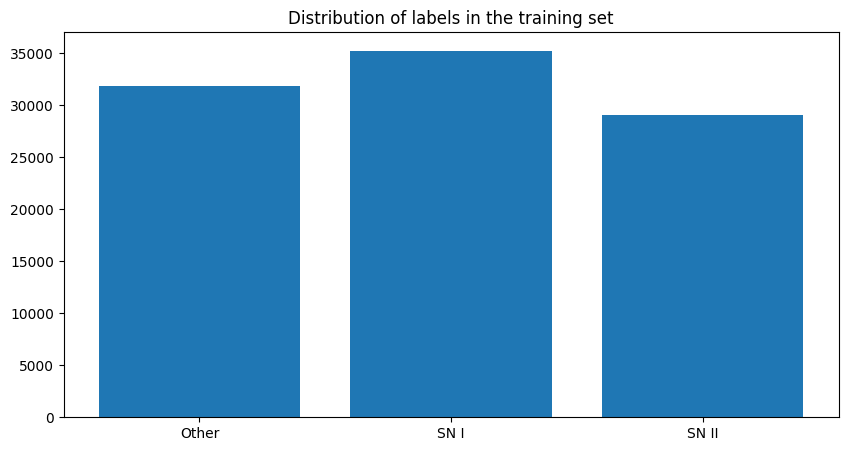

In [45]:
plt.figure(figsize=(10, 5))
plt.bar(label_names, y_train.sum(axis=0))
plt.title('Distribution of labels in the training set')
plt.show()

In [46]:
print("NaN in X_train:", np.isnan(X_train).any())
print("Inf in X_train:", np.isinf(X_train).any())

NaN in X_train: False
Inf in X_train: False


## Class weight

In [47]:
from sklearn.utils.class_weight import compute_class_weight

y_train_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_integers), y=y_train_integers)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

class_weight_dict

{0: 1.0063210992852134, 1: 0.9088735136770071, 2: 1.1037304866850322}

## T2 Model

![](assets/t2_model.png)

In [48]:
sequence_length = X_train.shape[1]
feature_dim = X_train.shape[2]
num_classes = y_train.shape[1]

print("Sequence length:", sequence_length)
print("Feature dimension:", feature_dim)
print("Number of classes:", num_classes)

Sequence length: 1000
Feature dimension: 4
Number of classes: 3


In [49]:
!pip install tensorflow_model_optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.6 MB/s eta 0:00:00a 0:00:01


In [50]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_model_optimization as tfmot
import numpy as np
from tensorflow.keras.utils import register_keras_serializable

class PrunableClusterableLayer(
    tf.keras.layers.Layer,
    tfmot.sparsity.keras.PrunableLayer,
    tfmot.clustering.keras.ClusterableLayer,
):
    def get_prunable_weights(self):
        # Prune kernel only, as pruning bias can harm model accuracy.
        return [self.conv1d.kernel]

    def get_clusterable_weights(self):
        # Cluster only the kernel as clustering bias usually harms model accuracy.
        return [("kernel", self.conv1d.kernel)]

    def get_clusterable_algorithm(self, weight_name):
        # Example algorithm, customize as necessary
        if weight_name == "kernel":
            return tfmot.clustering.keras.cluster_config.CentroidInitialization.LINEAR
        else:
            return None
        
class ConvEmbedding(PrunableClusterableLayer):
    def __init__(self, num_filters, kernel_size=1, activation='relu', **kwargs):
        super(ConvEmbedding, self).__init__(**kwargs)
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.activation = activation
        self.conv1d = layers.Conv1D(
            filters=self.num_filters, kernel_size=self.kernel_size, activation=self.activation
        )

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_filters": self.num_filters,
            "kernel_size": self.kernel_size,
            "activation": self.activation,
        })
        return config

    def call(self, inputs):
        return self.conv1d(inputs)
    
class PositionalEncoding(PrunableClusterableLayer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super(PositionalEncoding, self).__init__(dtype=dtype, **kwargs)
        self.max_steps = max_steps
        self.max_dims = max_dims

        if max_dims % 2 == 1:
            max_dims += 1
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000 ** (2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000 ** (2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(np.float32))

    def get_config(self):
        config = super().get_config()
        config.update({
            "max_steps": self.max_steps,
            "max_dims": self.max_dims,
        })
        return config

    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[1], :shape[2]]
    
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value, mask):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        if mask is not None:
            mask = tf.cast(mask, dtype=scaled_score.dtype)
            scaled_score += (mask * -1e9)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, mask):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value, mask)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output
    
class TransformerBlock(PrunableClusterableLayer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim

        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"), 
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
        })
        return config

    def call(self, inputs, training=False, mask=None):
        attn_output = self.att(inputs, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class MaskingLayer(layers.Layer):
    def __init__(self, mask_value=-999.0):
        super(MaskingLayer, self).__init__()
        self.mask_value = mask_value

    def call(self, inputs):
        mask = tf.math.not_equal(inputs, self.mask_value)
        mask = tf.reduce_any(mask, axis=-1)
        mask = mask[:, tf.newaxis, tf.newaxis, :]
        return inputs, mask
    
@register_keras_serializable()
class T2Model(tf.keras.Model):
    def __init__(self, num_filters, num_classes, num_layers, d_model, num_heads, dff, input_shape, rate=0.1):
        super(T2Model, self).__init__()
        self.num_filters = num_filters
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate

        self.masking_layer = MaskingLayer(mask_value=-999.0)
        self.embedding = ConvEmbedding(num_filters=self.num_filters)
        self.pos_encoding = PositionalEncoding(max_steps=input_shape[0], max_dims=d_model)
        self.encoder_layers = [TransformerBlock(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)
        self.final_layer = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x, mask = self.masking_layer(inputs)
        x = self.embedding(x)
        x = self.pos_encoding(x)
        
        for layer in self.encoder_layers:
            x = layer(x, training=training, mask=mask)

        x = layers.GlobalAveragePooling1D()(x)
        x = self.dropout(x, training=training)
        return self.final_layer(x)

    def build(self, input_shape):
        inputs = tf.keras.Input(shape=input_shape)
        _ = self.call(inputs)

In [51]:
from tensorflow.keras.optimizers import Adam
#from src.models.T2_model import T2Model

num_filters = 64
num_layers = 1
d_model = 64
num_heads = 16
dff = 128
rate = 0.1

model = T2Model(num_filters=num_filters, num_classes=num_classes, num_layers=num_layers,
                d_model=d_model, num_heads=num_heads, dff=dff, input_shape=(sequence_length, feature_dim), rate=rate)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

model.build(input_shape=(sequence_length, feature_dim))
model.summary()

Model: "t2_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_layer (MaskingLayer)    │ [(None, 1000, 4),      │             0 │
│                                 │ (None, 1, 1, 1000)]    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_embedding (ConvEmbedding)  │ (None, 1000, 64)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, 1000, 64)       │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 1000, 64)       │        33,472 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,987 (132.76 KB)

 Trainable params: 33,987 (132.76 KB)

 Non-trainable params: 0 (0.00 B)

## Callbacks

In [52]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
filepath = "data/best_model.keras"

callbacks_list = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30),
    ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, mode='min', verbose=1),
]

# Training

In [53]:
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    shuffle=True,
    callbacks=callbacks_list,
    class_weight=class_weight_dict)

Epoch 1/150
   1/1202 ━━━━━━━━━━━━━━━━━━━━ 5:18:55 16s/step - accuracy: 0.4062 - loss: 1.1130

I0000 00:00:1713835805.629098      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1202/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6108 - loss: 0.7822
Epoch 1: val_loss improved from inf to 0.69205, saving model to data/best_model.keras
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 265s 207ms/step - accuracy: 0.6108 - loss: 0.7822 - val_accuracy: 0.6387 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 2/150
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7013 - loss: 0.6312
Epoch 2: val_loss improved from 0.69205 to 0.50813, saving model to data/best_model.keras
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 234s 195ms/step - accuracy: 0.7014 - loss: 0.6311 - val_accuracy: 0.7821 - val_loss: 0.5081 - learning_rate: 0.0010
Epoch 3/150
 683/1202 ━━━━━━━━━━━━━━━━━━━━ 1:31 176ms/step - accuracy: 0.7915 - loss: 0.4781

KeyboardInterrupt: 

In [ ]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:
plot_history(history)

# Evaluation on Test data

In [ ]:
model.load_weights('/kaggle/working/data/best_model.keras')

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}')

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=label_names))

In [ ]:
plot_multi_class_roc(y_test, y_pred, label_names)

In [ ]:
plot_confusion_matrix(y_true, y_pred_classes, label_names)

In [ ]:
plot_class_accuracy(y_true, y_pred_classes, label_names)

In [ ]:
early_classification_tradeoff(model, X_test, y_test)

In [ ]:
def predict_and_average(model, X, y_df, label_names):
    original_ids = np.unique([obj_id.split('_')[0] for obj_id in y_df['obj_id']])
    predictions_list = []  # Utiliser une liste pour stocker les DataFrames temporaires

    for original_id in original_ids:
        obj_ids_mask = y_df['obj_id'].str.startswith(original_id)
        X_obj = X[obj_ids_mask]
        y_pred_prob = model.predict(X_obj)
        mean_probs = np.mean(y_pred_prob, axis=0)

        # Préparer la ligne de prédiction
        pred_row = {'obj_id': original_id}
        for idx, label in enumerate(label_names):
            pred_row[f'prob_{label}'] = mean_probs[idx]

        # Ajouter la ligne de prédiction à la liste
        predictions_list.append(pd.DataFrame([pred_row]))

    # Concaténer toutes les lignes de prédiction en un seul DataFrame
    predictions = pd.concat(predictions_list, ignore_index=True)

    return predictions

# Exemple d'utilisation
# Assurez-vous que model, X_test, y_test_df et label_names sont correctement définis
predictions_df = predict_and_average(model, X_test, y_test_df, label_names)
print(predictions_df)

In [ ]:
def predict_and_average(model, X, y_df, label_names):
    original_ids = np.unique([obj_id.split('_')[0] for obj_id in y_df['obj_id']])
    predictions_list = []  # Utiliser une liste pour stocker les DataFrames temporaires

    for original_id in original_ids:
        for suffix in ['', '_20', '_50', '_80']:
            # Identifier les obj_ids spécifiques pour chaque suffixe
            specific_obj_ids = y_df['obj_id'].str.startswith(original_id + suffix)
            if not specific_obj_ids.any():
                continue

            X_obj = X[specific_obj_ids]
            y_pred_prob = model.predict(X_obj)
            mean_probs = np.mean(y_pred_prob, axis=0)

            # Obtenir l'étiquette de vérité terrain du premier élément (supposé identique pour tous les éléments avec le même obj_id)
            ground_truth = y_df[specific_obj_ids]['type'].values[0]

            # Préparer la ligne de prédiction avec le suffixe dans obj_id si nécessaire
            pred_obj_id = original_id if suffix == '' else original_id + suffix
            pred_row = {'obj_id': pred_obj_id, 'ground_truth': ground_truth}
            for idx, label in enumerate(label_names):
                pred_row[f'prob_{label}'] = mean_probs[idx]

            # Ajouter la ligne de prédiction à la liste
            predictions_list.append(pd.DataFrame([pred_row]))

    # Concaténer toutes les lignes de prédiction en un seul DataFrame
    predictions = pd.concat(predictions_list, ignore_index=True)

    return predictions

predictions_df = predict_and_annotate(model, X_test, y_test_df, label_names)

In [ ]:
def display_global_performance(predictions_df):
    # Calculer la moyenne des probabilités pour chaque classe
    mean_probs = predictions_df.mean(axis=0, numeric_only=True)
    print("Performance Globale Moyenne par Classe:")
    print(mean_probs)

In [ ]:
display_global_performance(predictions_df)

In [ ]:
def display_augmentation_performance(predictions_df):
    # Extraire les types de chaque objet ID (original, _20, _50, _80)
    augment_types = ['_20', '_50', '_80', 'original']
    results = {}

    for aug_type in augment_types:
        if aug_type == 'original':
            mask = predictions_df['obj_id'].apply(lambda x: '_' not in x)
        else:
            mask = predictions_df['obj_id'].str.startswith(aug_type)

        # Calculer la moyenne des probabilités pour le type courant
        filtered_df = predictions_df[mask]
        mean_probs = filtered_df.mean(axis=0, numeric_only=True)
        results[aug_type] = mean_probs
        print(f"Performance Moyenne pour {aug_type}:")
        print(mean_probs)

    return results

In [ ]:
predictions_df

In [ ]:
y_test_df

In [ ]:
display_augmentation_performance(predictions_df)